In [8]:
!pip install tensorflow tensorflow-datasets

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/5.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/5.1 MB 1.6 MB/s eta 0:00:04
   - -------------------------------------- 0.1/5.1 MB 1.7 MB/s eta 0:00:03
   - -------------------------------------- 0.2/5.1 MB 2.3 MB/s eta 0:00:03
   --- ------------------------------------ 0.4/5.1 MB 2.3 MB/s eta 0:00:03
   --- ------------------------------------ 0.5/5.1 MB 2.4 MB/s eta 0:00:02
   ---- ----------------------------------- 0.6/5.1 MB 2.5 MB/s eta 0:00:02
   ----- ---------------------------------- 0.7/5.1 MB 2.4 MB/s eta 0:00:02
   ------ --------------------------------- 0.8/5.1 MB 2.4 MB/s eta 0:00:02
   ------ --------------------------------- 0.8/5.1 MB 2.1 MB/s eta 0:00:03
   ------- -------------------------------- 0.9/5.1 MB 2.2 MB/s eta 0:00:02
   ------- -------------------------------- 1.0/5.1 MB 2.1 MB/s eta 0


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/balanced/3.1.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST Balanced
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='C:\\Users\\whysu\\tensorflow_datasets\\emnist\\balanced\\3.1.0',
    file_format=tfrecord,
    download_size=535.73 MiB,
    dataset_size=56.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=47),
    }),
 

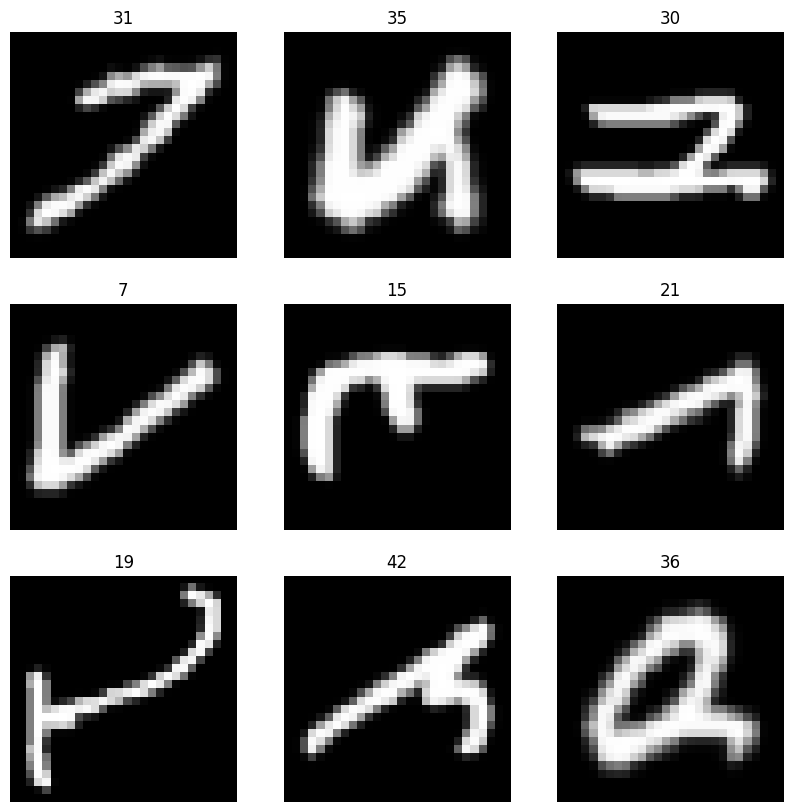

In [10]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the EMNIST dataset using TensorFlow Datasets (tfds)
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/balanced', 
    split=['train', 'test'], 
    shuffle_files=True,
    as_supervised=True,  # Returns (image, label) pairs
    with_info=True
)

# Display dataset info
print(ds_info)

# Normalize images: Convert uint8 data to float32 (0-1 range)
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch the data for performance
ds_train = ds_train.batch(64).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

# Plot a few sample images
for image, label in ds_train.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().squeeze(), cmap='gray')
        plt.title(int(label[i]))
        plt.axis('off')


In [13]:
from tensorflow.keras import layers, models

# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(47, activation='softmax')  # 47 classes in the balanced dataset
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse labels (not one-hot encoded)
              metrics=['accuracy'])

# Train the model
model.fit(ds_train, epochs=5, validation_data=ds_test)

# Save the model
model.save("emnist_digit_letter_classifier.keras")


Epoch 1/5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.6579 - loss: 1.1826 - val_accuracy: 0.8478 - val_loss: 0.4520
Epoch 2/5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.8569 - loss: 0.4061 - val_accuracy: 0.8618 - val_loss: 0.4055
Epoch 3/5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.8768 - loss: 0.3420 - val_accuracy: 0.8676 - val_loss: 0.3879
Epoch 4/5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.8869 - loss: 0.3057 - val_accuracy: 0.8691 - val_loss: 0.3895
Epoch 5/5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.8951 - loss: 0.2770 - val_accuracy: 0.8703 - val_loss: 0.3910


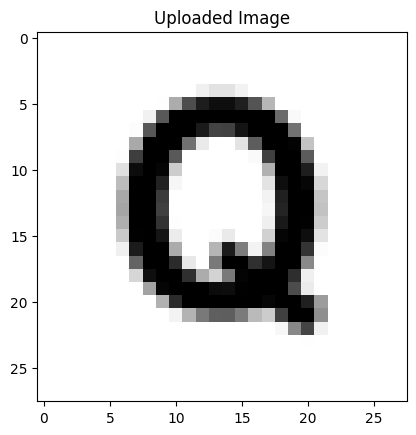

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted character: Q


In [26]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('emnist_digit_letter_classifier.keras')

# Function to preprocess user-uploaded image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize((28, 28))  # Resize to 28x28 pixels
    img = np.array(img) / 255.0  # Normalize
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Path to the uploaded image (replace with the user's image path)
image_path = 'C:\\Users\\whysu\\Downloads\\images.png'
preprocessed_image = preprocess_image(image_path)

# Display the image before prediction
plt.imshow(preprocessed_image.squeeze(), cmap='gray')
plt.title("Uploaded Image")
plt.show()

# Predict using the model
prediction = model.predict(preprocessed_image)
predicted_label = np.argmax(prediction)

# Label mapping for EMNIST Balanced (digits, letters, etc.)
emnist_labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'  # 47 classes
print(f"Predicted character: {emnist_labels[predicted_label]}")
